# Problema a ser resolvido:

------

- Tenho uma carteira com 10 ações. Dado a distribuição dos retornos dessa carteira no último ano:

    * Qual o máximo que eu posso perder no próximo ano, com uma confiança de 95%?
    * Qual a probabilidade de eu obter lucro?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from numpy import linalg as LA

In [ ]:
#pegando dados

# lista_acoes = ['WEGE3', 'PCAR3', 'LREN3', 'PETR4', 'VALE3']
lista_acoes = ["BBAS3", "BBDC4", "ABCB4", "CEAB3", "TRPL4", "SIMH3", "SLCE3", "POSI3", "CAMB3", "VAMO3"]
lista_acoes = [acao + ".SA" for acao in lista_acoes]

data_final = dt.datetime.now()
data_inicial = data_final - dt.timedelta(days=300)

precos = yf.download(lista_acoes, data_inicial, data_final)['Adj Close']

In [43]:
#calculando retornos pegando matriz de covariância 

retornos = precos.pct_change().dropna()
media_retornos = retornos.mean()
matriz_covariancia = retornos.cov()
pesos_carteira = np.full(len(lista_acoes), 1/len(lista_acoes))
numero_acoes = len(lista_acoes)

pesos_carteira

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

# Fórmula retornos sintéticos
---
Retornos_sintéticos = média_retornos + Rpdf × L.

* média_retornos = Média dos retornos.
* Rpdf = Matriz aleatória gerada por alguma função de densidade de probabilidade.
* L = Matriz triangular inferior proveniente de uma decomposição de Cholesky, usando como base a matriz de covariância dos dados originais.


# Por que fazer isso?
---

Nós assumimos que a distribuição de retornos é uma distribuição normal multivariada (isso é uma expansão da distribuição normal).

Quando geremos retornos aleátorios de cada ativo (Weg, Vale, etc), nós criamos vetores aleatórios descorrelacionados entre si. Para corrigir isso, precisamos correlacionar esses retornos (no mundo real isso é o que acontece) e, para isso, usamos a matriz triângular obtida a partir da covariância.

In [44]:
#premissas montecarlo

numero_simulacoes = 10000
dias_projetados = 252 
capital_inicial = 1000

In [45]:
#gerando retorno médio
retorno_medio = retornos.mean(axis = 0).to_numpy() 
matriz_retorno_medio = retorno_medio * np.ones(shape = (dias_projetados, numero_acoes))

In [46]:
#gerando L
L = LA.cholesky(matriz_covariancia)
L

array([[ 0.01709149,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.00596263,  0.01269927,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.00874592,  0.00371115,  0.01253465,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.00394061,  0.00191166,  0.00520019,  0.02827205,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.00999393,  0.00676387,  0.00517453,  0.01274711,  0.03746261,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.01196622,  0.00879535,  0.0020807 ,  0.00417299,  0.00887093,
         0.02635986,  0.        ,  0.        ,  0.        ,  0.        ,
         0.   

In [47]:
#gerando simulações

retornos_carteira = np.zeros([dias_projetados, numero_simulacoes]) #cada coluna é uma simulação
montante_final = np.zeros(numero_simulacoes)

for s in range(numero_simulacoes):

    Rpdf = np.random.normal(size=(dias_projetados, numero_acoes)) 
    
    retornos_sintéticos = matriz_retorno_medio + np.inner(Rpdf, L) #unica coisa random é o Rpdf
    
    retornos_carteira[:, s] = np.cumprod(np.inner(pesos_carteira, 
                                                  retornos_sintéticos) + 1) * capital_inicial
    montante_final[s] = retornos_carteira[-1, s]
    
    
retornos_carteira

array([[1015.37970852, 1014.07028175, 1012.13354166, ...,  986.98811488,
         982.14484084,  998.4098745 ],
       [1026.17186418, 1010.76288856, 1011.3473    , ...,  996.12293936,
         984.47312012,  994.02101397],
       [1022.47082912, 1039.82904745, 1020.77884285, ...,  992.57723232,
         976.22426569,  996.63407714],
       ...,
       [1604.56413326, 2390.0096672 , 1551.87077321, ..., 1668.68649671,
        1381.32522658, 1410.30482434],
       [1615.72756198, 2387.67511438, 1519.73683677, ..., 1667.03404721,
        1379.97561317, 1413.91759906],
       [1597.489993  , 2403.9582467 , 1526.70891043, ..., 1707.39779165,
        1379.71512127, 1423.58270557]])

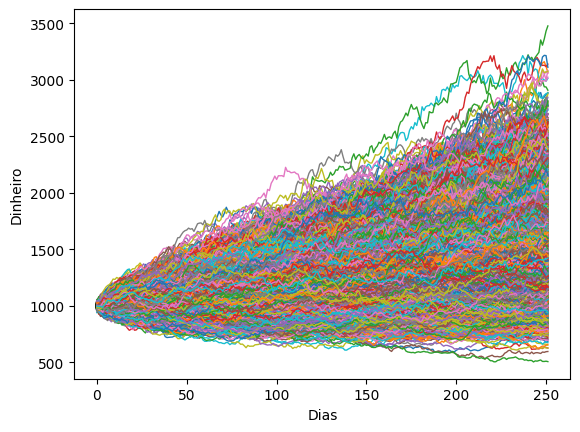

In [48]:
plt.plot(retornos_carteira, linewidth=1)
plt.ylabel('Dinheiro')
plt.xlabel('Dias')
plt.show()

In [49]:
montante_99 = str(np.percentile(montante_final, 1))
montante_95 = str(np.percentile(montante_final, 5))
montante_mediano = str(np.percentile(montante_final, 50))
cenarios_com_lucro = str((len(montante_final[montante_final > 1000])/
                                len(montante_final)) * 100) + "%"

In [50]:
print(f'''Ao investir R$ 1000,00 na carteira {lista_acoes}, 
podemos esperar esses resultados para os próximo ano, 
utilizando o método de Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que R$ {montante_mediano}. 

Com 95% de probabilidade, o montante será maior que R$ {montante_95}.

Com 99% de probabilidade, o montante será maior que R$ {montante_99}.

Em {cenarios_com_lucro} dos cenários, foi possível obter lucro no próximo ano.''')

Ao investir R$ 1000,00 na carteira ['BBAS3.SA', 'BBDC4.SA', 'ABCB4.SA', 'CEAB3.SA', 'TRPL4.SA', 'SIMH3.SA', 'SLCE3.SA', 'POSI3.SA', 'CAMB3.SA', 'VAMO3.SA', 'VALE3.SA'], 
podemos esperar esses resultados para os próximo ano, 
utilizando o método de Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que R$ 1432.7851657140695. 

Com 95% de probabilidade, o montante será maior que R$ 976.5624088693315.

Com 99% de probabilidade, o montante será maior que R$ 846.2350157276021.

Em 93.89% dos cenários, foi possível obter lucro no próximo ano.


# Utilidades

A partir dessas métricas, é possível calcular coisas como o VAR da carteira para diferentes intervalos de confiança e medir se o risco que você está correndo é compatível com o que você aguenta perder. No caso dessa carteira, uma queda de 27,5% está dentro dos 95% dos cenários mais possíveis de acontecer no próximo ano.

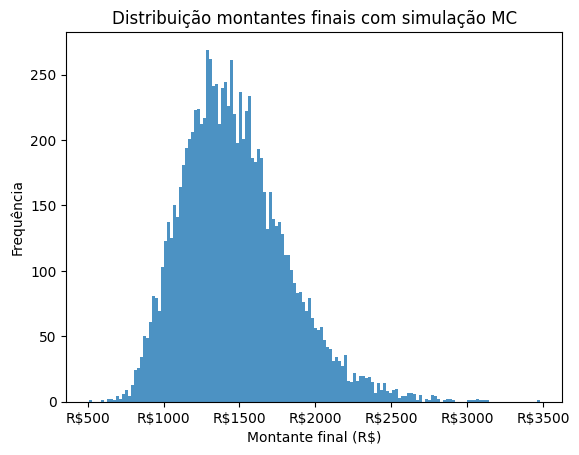

In [51]:
config = dict(histtype = "stepfilled", alpha = 0.8, density = False, bins = 150)
fig, ax = plt.subplots()
ax.hist(montante_final, **config)
ax.xaxis.set_major_formatter('R${x:.0f}')
plt.title('Distribuição montantes finais com simulação MC')
plt.xlabel('Montante final (R$)')
plt.ylabel("Frequência")
plt.show()